### Overview

In [36]:
from IPython.display import HTML
#Add button to toggle code - http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle code."></form>''')

In [165]:
%matplotlib inline

from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.client import GoogleCredentials
import itertools
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display
from IPython.display import Image

matplotlib.style.use('ggplot')

#Set GOOGLE_APPLICATION_CREDENTIALS environment variable
credentials = GoogleCredentials.get_application_default()
bigquery_service = build('bigquery', 'v2', credentials=credentials)

with open('config.json') as json_config:
    config = json.load(json_config)
    
project_id = config['project_id']

In [48]:
query_request = bigquery_service.jobs()

query = '''select
            type, %s as payload_type, count(type)
            from githubarchive:month.%s
            where type = 'CreateEvent'
            group by 1,2 limit 100;'''

years = ['2014','2015','2016']
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
dates = [y+m for y,m in list(itertools.product(years,months))]
query_results = []
for date in dates[:4]:
    try:
        #data format changes in January 2015 - use different column names before and after
        column_name = 'payload_ref_type' if int(date) < 201500 else "JSON_EXTRACT(payload, '$.ref_type')"
        query_data = {
                    'query': (query %(column_name, date))
        }
        query_response = query_request.query(
                    projectId=project_id,
                    body=query_data).execute()
        
        for row in query_response['rows']:
            payload_type = row['f'][1]['v']
            value = int(row['f'][2]['v'])
            query_results.append({'date':date, 'payload_type':payload_type, 'value':value})
    except: pass

Before we dig into commits, lets check out some summary statistics.  There were x new repositories created in December 2015 with x push events containing x total commits.  No surprises - github is growing:

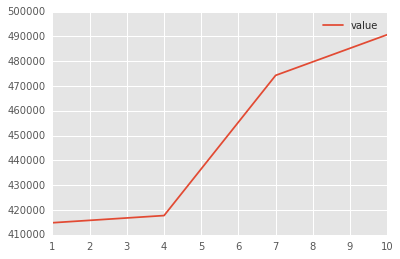

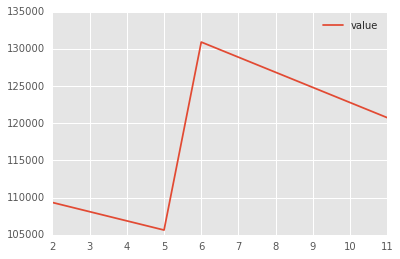

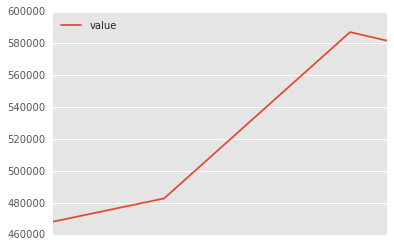

In [49]:
df = pd.DataFrame(query_results)
df['date'] = pd.to_datetime(df.date, format='%Y%m')
df.set_index(df['date'])
df[df['payload_type']=='repository'][['value']].plot(label='Repositories')
df[df['payload_type']=='tag'][['value']].plot(label='Tags')
df[df['payload_type']=='branch'][['value']].plot(label='Branches')

#data = df[['date','value']].plot()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

Lets take a look at the top commit messages:

In [59]:
#Chart: First Words
commit_query_request = bigquery_service.jobs()

#Get Top 5000 commit messages (lower case) with message counts and unique repo counts for 2015
query = '''
SELECT
LOWER(message), 
COUNT(LOWER(message)) as message_count,
EXACT_COUNT_DISTINCT(repo_id) as unique_repo_count
FROM (
  SELECT
  id,
  repo_id,
  REGEXP_EXTRACT(SPLIT(JSON_EXTRACT(payload, '$.commits'),"},{"),r'"message":"(.+)",') AS message 
  FROM TABLE_QUERY([githubarchive:month],'REGEXP_MATCH(table_id, r"^2015.+")')
  WHERE type = 'PushEvent'
  AND JSON_EXTRACT(payload, '$.commits') != '[]'
)
group by 1 order by 2 desc limit 5000
'''

commit_query_response = commit_query_request.query(
            projectId=project_id,
            body={'query':query,'timeoutMs':5000000}).execute()
commit_query_results = []
for row in commit_query_response['rows']:
    commit_message = row['f'][0]['v']
    message_count = int(row['f'][1]['v'])
    unique_repo_count = int(row['f'][2]['v'])
    commit_query_results.append({
            'commit_message':commit_message, 
            'message_count':message_count, 
            'unique_repo_count':unique_repo_count})

In [68]:
commit_df = pd.DataFrame(commit_query_results)

In [85]:
commit_df['rank']= commit_df['message_count'].rank(ascending=False)
commit_df=commit_df.set_index('rank')
commit_df.head(25)

,commit_message,message_count,unique_repo_count
rank,,,
1,update readme.md,2463375,857734
2,update,1444117,159522
3,update index.html,490255,90740
4,create readme.md,465997,431775
5,'privacy sync',432552,44
6,initial commit,431046,295502
7,test,421555,145133
8,auto,404816,590
9,commit,273705,42551


Above we have the top 25 commit messages for 2015.  Alot of readmes have been updated.  There are also some messages that occur frequently in a small number of repos - *'privacy sync'* and test - *clear repository branch* for example.

In [226]:
commit_stat_request = bigquery_service.jobs()

query = '''SELECT
REGEXP_MATCH(LOWER(message), r'^\S+(ed)\S* .+') as past_tense,
REGEXP_MATCH(message, r'^([A-Z]).+') as capitalized,
message CONTAINS '\\\\n' AS multiline_message,
count(message) AS count
FROM (
  SELECT
  id,
  repo_id,
  REGEXP_EXTRACT(SPLIT(JSON_EXTRACT(payload, '$.commits'),"},{"),r'"message":"(.+)",') AS message 
  FROM [github_sample_data.month_sample]
  --FROM TABLE_QUERY([githubarchive:month],'REGEXP_MATCH(table_id, r"^2015.+")')
  WHERE type = 'PushEvent'
  AND JSON_EXTRACT(payload, '$.commits') != '[]'
)
group by 1,2,3
'''
commit_stat_response = commit_stat_request.query(
            projectId=project_id,
            body={'query':query,'timeoutMs':5000000}).execute()
commit_stat_results = []
for row in commit_stat_response['rows']:
    past_tense = row['f'][0]['v']
    capitalized = row['f'][1]['v']
    multiline_message = row['f'][2]['v']
    count = int(row['f'][3]['v'])
    commit_stat_results.append({
            'past_tense':past_tense, 
            'capitalized':capitalized,
            'multiline_message':multiline_message,
            'count':count})

In [228]:
commit_stat_results

[{'capitalized': u'false',
  'count': 1182,
  'multiline_message': u'false',
  'past_tense': u'false'},
 {'capitalized': u'true',
  'count': 492,
  'multiline_message': u'true',
  'past_tense': u'false'},
 {'capitalized': u'true',
  'count': 1559,
  'multiline_message': u'false',
  'past_tense': u'false'},
 {'capitalized': u'true',
  'count': 304,
  'multiline_message': u'false',
  'past_tense': u'true'},
 {'capitalized': u'false',
  'count': 210,
  'multiline_message': u'false',
  'past_tense': u'true'},
 {'capitalized': u'false',
  'count': 286,
  'multiline_message': u'true',
  'past_tense': u'false'},
 {'capitalized': u'false',
  'count': 12,
  'multiline_message': u'true',
  'past_tense': u'true'},
 {'capitalized': u'true',
  'count': 25,
  'multiline_message': u'true',
  'past_tense': u'true'},
 {'capitalized': None,
  'count': 0,
  'multiline_message': None,
  'past_tense': None}]

There are [many](http://chris.beams.io/posts/git-commit/) [github](http://tbaggery.com/2008/04/19/a-note-about-git-commit-messages.html) [commit message](https://git-scm.com/book/ch5-2.html) [guides](https://github.com/erlang/otp/wiki/Writing-good-commit-messages) out there.  I borrowed a few rules from [Chris Beam's](http://chris.beams.io/posts/git-commit/) guide:
- Use the imperative tense (e.g. use add vs added)
- Capitalize the first letter
- Separate subject from body with a blank line
- Limit the subject line to 50 characters

Lets see what people actually do:

In [235]:
from bokeh.plotting import *

commit_stat_df = pd.DataFrame(commit_stat_results)
#capitalized = commit_stat_df[['capitalized', 'count']].groupby('capitalized').sum()
#past_tense = commit_stat_df[['past_tense', 'count']].groupby('past_tense').sum()
#multiline_message = commit_stat_df[['multiline_message', 'count']].groupby('multiline_message').sum()

output_notebook(hide_banner=True)

def create_percentage_plot(_df, metric_name, title, reverse=False):
    df = _df[[metric_name, 'count']].groupby(metric_name).sum()
    df['percentage']=df['count']/df['count'].sum()
    df=df.reset_index()
    percentage_true = df[df[metric_name]=='true']['percentage'].values[0]
    if reverse:
        percentage_true = 1-percentage_true
    item_count = df[['count']].sum().values[0]
    title = title + ' (n='+str(item_count)+')'
    p = figure(width=300, height=250, toolbar_location=None, 
               tools=[], title=title, title_text_font_size='12pt', title_text_font='Lato')
    p.quad(top=[percentage_true], bottom=[0], left=[0], right=[1], color="#0B486B") #True Box
    p.quad(top=[1], bottom=[percentage_true], left=[0], right=[1], color="#CFF09E") #False Box
    p.text(.5, .02, text=["{0:.2f}".format(percentage_true*100) + '% - Yes'], text_font='Lato', text_color="white", text_align="center", text_baseline='bottom', text_font_size="12pt")
    p.text(.5, .98, text=["{0:.2f}".format(100-percentage_true*100) + '% - No'], text_font='Lato', text_color="black", text_align="center", text_baseline='top', text_font_size="12pt")
    p.axis.visible = None
    p.grid.grid_line_color = None
    return p

p = gridplot([
        [
            create_percentage_plot(commit_stat_df, 'capitalized', 'First letter is capitalized'),
            create_percentage_plot(commit_stat_df, 'multiline_message', 'Contains multiple lines'),
            create_percentage_plot(commit_stat_df, 'past_tense', 'Uses the imperative tense', reverse=True)
        ]
    ])
show(p)

Of course any data project has strange outliers - this one is no different.  

There is [this project](https://github.com/simonAllier/benoit-exp-result) which manages to have over 350,000 commits at the time of writing.

Also, 'Tell the children the truth.' struck my eye as an odd commit choice.  Turns out github user [treckstar](https://github.com/treckstar) has written a script to commit every hour for the last few years or so.  Check out that streak ([And why not star his project while you are at it](https://github.com/treckstar/yolo-octo-hipster)?)

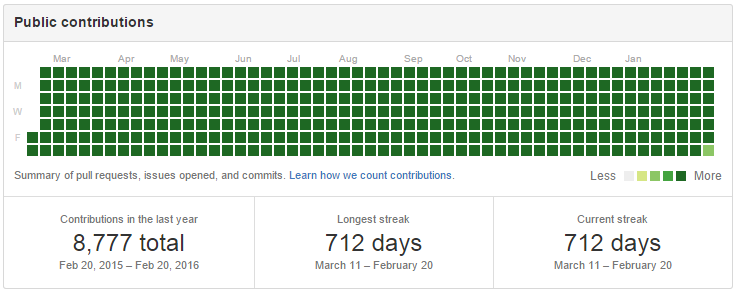

In [166]:
Image(filename='streak.png')